In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import datajoint as dj
from datetime import datetime
from pathlib import Path
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import workflow
from matplotlib import pyplot as plt
import spikeinterface as si
from spikeinterface import extractors
from spikeinterface import widgets
import probeinterface as pi
from probeinterface import plotting
from workflow.pipeline import *
from workflow.utils.ingestion_utils import El2ROW
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory

[2024-01-24 17:35:25,591][INFO]: Connecting utah-worker@db.datajoint.com:3306
[2024-01-24 17:35:25,988][INFO]: Connected utah-worker@db.datajoint.com:3306


In [ ]:
workflow.get_workflow_operation_overview()

,process,worker_name,total,in_queue,reserved,error,ignore,remaining
0,analysis.LFPSpectrogram,standard_worker,13437,6642,0,5,8535,-1898
1,ephys.EphysSessionInfo,standard_worker,2159,812,0,55,0,757
2,ephys.LFP,standard_worker,2156,1603,1,35,0,1567
3,ingestion_support.FileProcessing,standard_worker,102362,56,0,0,0,56


In [ ]:
display(culture.Experiment().proj("experiment_end_time", "drug_name", "drug_concentration", "experiment_plan").fetch(format="frame").reset_index())

,organoid_id,experiment_start_time,experiment_end_time,drug_name,drug_concentration,experiment_plan
0,O09,2023-05-18 12:25:00,2023-05-18 18:15:00,4-AP,100.0,ephys
1,O09,2023-05-18 18:15:00,2023-05-19 09:30:00,No Drug,NaN,ephys
2,O09,2023-05-19 09:30:00,2023-05-19 15:35:00,Bicuculline,50.0,ephys
3,O09,2023-05-19 15:45:00,2023-05-20 15:40:00,Tetrodotoxin,1.0,ephys
4,O10,2023-05-18 12:25:00,2023-05-18 18:15:00,4-AP,100.0,ephys
5,O10,2023-05-18 18:15:00,2023-05-19 09:30:00,No Drug,NaN,ephys
6,O10,2023-05-19 09:30:00,2023-05-19 15:35:00,Bicuculline,50.0,ephys
7,O10,2023-05-19 15:45:00,2023-05-20 15:40:00,Tetrodotoxin,1.0,ephys
8,O11,2023-05-18 12:25:00,2023-05-18 18:15:00,4-AP,100.0,ephys
9,O11,2023-05-18 18:15:00,2023-05-19 09:30:00,No Drug,NaN,ephys


### Create `spike_sorting` sessions

In [ ]:
session_info = dict(
    organoid_id = "O09",
    experiment_start_time="2023-05-18 12:25:00",
    insertion_number=0,
    start_time = "2023-05-18 12:25:00",
    end_time = "2023-05-18 12:30:00",
    session_type="spike_sorting",
    )

session_probe_info = dict(
    organoid_id = "O09",
    experiment_start_time="2023-05-18 12:25:00",
    insertion_number=0,
    start_time = "2023-05-18 12:25:00",
    end_time = "2023-05-18 12:30:00",
    probe="Q983",  # probe serial number
    port_id="A",  # Port ID ("A", "B", etc.)
    used_electrodes=[]  # empty if all electrodes were used
    )

In [ ]:
# Insert the session
ephys.EphysSession.insert1(session_info, ignore_extra_fields=True, skip_duplicates=True)

ephys.EphysSessionProbe.insert1(
    session_probe_info, ignore_extra_fields=True, skip_duplicates=True)

del session_probe_info["used_electrodes"]
display(ephys.EphysSession & session_info)
display(ephys.EphysSessionProbe & session_probe_info)

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,spike_sorting


organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,probe unique identifier for this model of probe (e.g. serial number),port_id,"used_electrodes list of electrode IDs used in this session (if null, all electrodes are used)"
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,Q983,A,=BLOB=


### Load data

In [ ]:
query = culture.Experiment().proj("drug_name") * ephys.EphysSession & {"session_type": "spike_sorting"} 
key = (query & session_info).fetch1()

title = "_".join([key["organoid_id"], key["start_time"].strftime("%Y%m%d%H%M"), key["end_time"].strftime("%Y%m%d%H%M"), key["drug_name"].replace(" ", "")])

spike_sorting_path = get_processed_root_data_dir() / "spike_sorting" / title
spike_sorting_path.mkdir(exist_ok=True)

files, file_times = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
).fetch("file_path", "file_time", order_by="file_time")

[print(file) for file in files]
print(f"\nNumber of files: {len(files)} ({key['drug_name']})")

[2024-01-24 16:33:36,715][WARNING]: MySQL server has gone away. Reconnecting to the server.


O09-12_raw/processed_O9-12_230518_122506.rhd
O09-12_raw/processed_O9-12_230518_122606.rhd
O09-12_raw/processed_O9-12_230518_122706.rhd
O09-12_raw/processed_O9-12_230518_122806.rhd
O09-12_raw/processed_O9-12_230518_122906.rhd

Number of files: 5 (4-AP)


In [ ]:
# 1. Read the raw data as a recording object.
# 2. Concatenate the object for one session.

stream_name = "RHD2000 amplifier channel"

if (spike_sorting_path / "recording.pkl").exists():
    recording = si.load_extractor(spike_sorting_path / "recording.pkl")
else:
    recording = None
    t_start = file_times[0]
    for file in [find_full_path(get_ephys_root_data_dir(), f) for f in files]:
        print(f"Processing {file}.")
        if not recording:
            recording = si.extractors.read_intan(file, stream_name=stream_name)
        else:
            recording = si.concatenate_recordings([recording, si.extractors.read_intan(file, stream_name=stream_name)])
            
    recording.dump_to_pickle(file_path=spike_sorting_path / "recording.pkl")  # lazy dumping (not actual traces, only the information on how to reconstruct the recording gets dumped)
    # recording.save(folder=spike_sorting_path)  # save on disk
recording

ConcatenateSegmentRecording: 128 channels - 20.0kHz - 1 segments - 6,000,000 samples 
                             300.00s (5.00 minutes) - uint16 dtype - 1.43 GiB

In [ ]:
# recording.get_traces(return_scaled=True)  # return values in uV
# recording.get_times() # get timestamps
# recording.get_time_info()  # {'sampling_frequency': 20000.0, 't_start': None, 'time_vector': None}
# recording.neo_reader
# recording.has_time_vector()  # false
# recording.sampling_frequency

### Generate probe

In [ ]:
# Get probe info
manufacturer = 'neuronexus'
probe_info = (ephys.EphysSessionProbe & key).fetch1()
probe_type = ((probe.Probe * ephys.EphysSessionProbe()) & key).fetch1("probe_type")

electrode_query = probe.ElectrodeConfig.Electrode & (
    probe.ElectrodeConfig & {"probe_type": probe_type}
)
number_of_electrodes = len(electrode_query)

# Filter for used electrodes. If probe_info["used_electrodes"] is None, it means all electrodes were used.
probe_info["used_electrodes"] = probe_info["used_electrodes"] or list(range(number_of_electrodes))
unused_electrodes = [elec for elec in range(number_of_electrodes) if elec not in probe_info["used_electrodes"]]
electrode_query &= (
    f'electrode IN {tuple(probe_info["used_electrodes"])}'
)
    
channel_to_electrode_map = dict(zip(*electrode_query.fetch("channel", "electrode")))

channel_to_electrode_map = {
    f'{probe_info["port_id"]}-{int(channel):03d}': electrode
    for channel, electrode in channel_to_electrode_map.items()
}
print(channel_to_electrode_map)
lfp_indices = np.sort(np.array(electrode_query.fetch("channel"), dtype=int))

# # Useful APIs
# p.device_channel_indices
# p.contact_ids

{'A-019': 0, 'A-004': 1, 'A-018': 2, 'A-005': 3, 'A-017': 4, 'A-006': 5, 'A-031': 6, 'A-008': 7, 'A-030': 8, 'A-009': 9, 'A-029': 10, 'A-010': 11, 'A-020': 12, 'A-003': 13, 'A-021': 14, 'A-002': 15, 'A-022': 16, 'A-001': 17, 'A-024': 18, 'A-015': 19, 'A-025': 20, 'A-014': 21, 'A-026': 22, 'A-013': 23, 'A-027': 24, 'A-012': 25, 'A-023': 26, 'A-000': 27, 'A-028': 28, 'A-011': 29, 'A-016': 30, 'A-007': 31}


,x,y,contact_shapes,radius,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
19,0.0,0.0,circle,15.0,,0,19,um,1.0,0.0,0.0,1.0
4,0.0,100.0,circle,15.0,,1,4,um,1.0,0.0,0.0,1.0
18,0.0,200.0,circle,15.0,,2,18,um,1.0,0.0,0.0,1.0
5,0.0,300.0,circle,15.0,,3,5,um,1.0,0.0,0.0,1.0
17,0.0,400.0,circle,15.0,,4,17,um,1.0,0.0,0.0,1.0
6,0.0,500.0,circle,15.0,,5,6,um,1.0,0.0,0.0,1.0
31,0.0,600.0,circle,15.0,,6,31,um,1.0,0.0,0.0,1.0
8,0.0,700.0,circle,15.0,,7,8,um,1.0,0.0,0.0,1.0
30,0.0,800.0,circle,15.0,,8,30,um,1.0,0.0,0.0,1.0
9,0.0,900.0,circle,15.0,,9,9,um,1.0,0.0,0.0,1.0


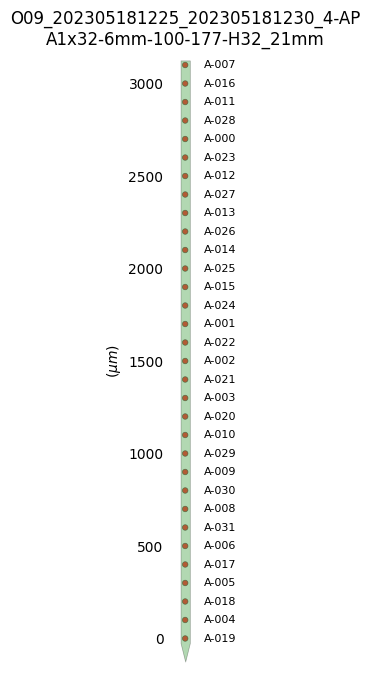

In [ ]:
# Create a custom plot using the probe information
fig, ax = plt.subplots(figsize=(8, 8))

# Create a session probe
linear_probe = pi.generate_linear_probe(num_elec=32, ypitch=100, contact_shape_params={'radius': 15})
linear_probe.set_device_channel_indices(El2ROW)

try:
    contact_colors = ["r" if e in probe_info["used_electrodes"] else "w" for e in range(number_of_electrodes)]  # red for used channels
except TypeError:
    contact_colors = list("r" * number_of_electrodes)

# Plot the probe   
pi.plotting.plot_probe(linear_probe, ax=ax, contacts_colors=contact_colors)
[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_ticks_position("none")  # Remove y-axis tick marks
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("($\\mu m$)", fontsize=10)
ax.set_title(title + "\n" + probe_type)
contact_positions = linear_probe.contact_positions
device_channel_indices = [f"{probe_info['port_id']}-{ch:03}" for ch in linear_probe.device_channel_indices]

for (x, y), txt in zip(contact_positions, device_channel_indices):
    ax.text(x + 100, y, txt, va="center", fontsize=8)

if not (spike_sorting_path / "probe.pdf").exists():
    fig.savefig(spike_sorting_path / "probe.pdf")

recording = recording.set_probe(linear_probe)
recording.get_probe().to_dataframe(complete=True).sort_values(by="contact_ids", key=lambda col: col.astype(int))

#### Preprocessing

In [ ]:
  # Remove unused electrodes
if unused_electrodes:
    recording = recording.remove_channels(
        remove_channel_ids=np.array([str(elec) for elec in unused_electrodes])
    )
print(recording)
print(recording.get_probe())

ChannelSliceRecording: 32 channels - 20.0kHz - 1 segments - 6,000,000 samples 
                       300.00s (5.00 minutes) - uint16 dtype - 366.21 MiB
Probe - 32ch - 1shanks


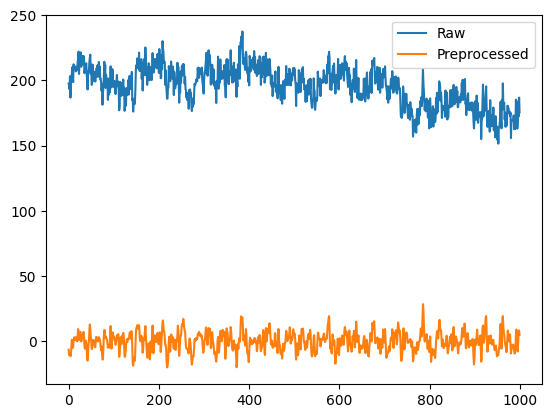

In [ ]:
from spikeinterface import preprocessing

recording_f = si.preprocessing.bandpass_filter(recording=recording, freq_min=300, freq_max=6000)
recording_cmr = si.preprocessing.common_reference(recording=recording_f, operator="median")

trace_raw = recording.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)
trace_preprocessed = recording_cmr.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)

plt.plot(trace_raw [:, 0], label='Raw')
plt.plot(trace_preprocessed[:, 0], label='Preprocessed')
plt.legend()

del trace_raw, trace_preprocessed

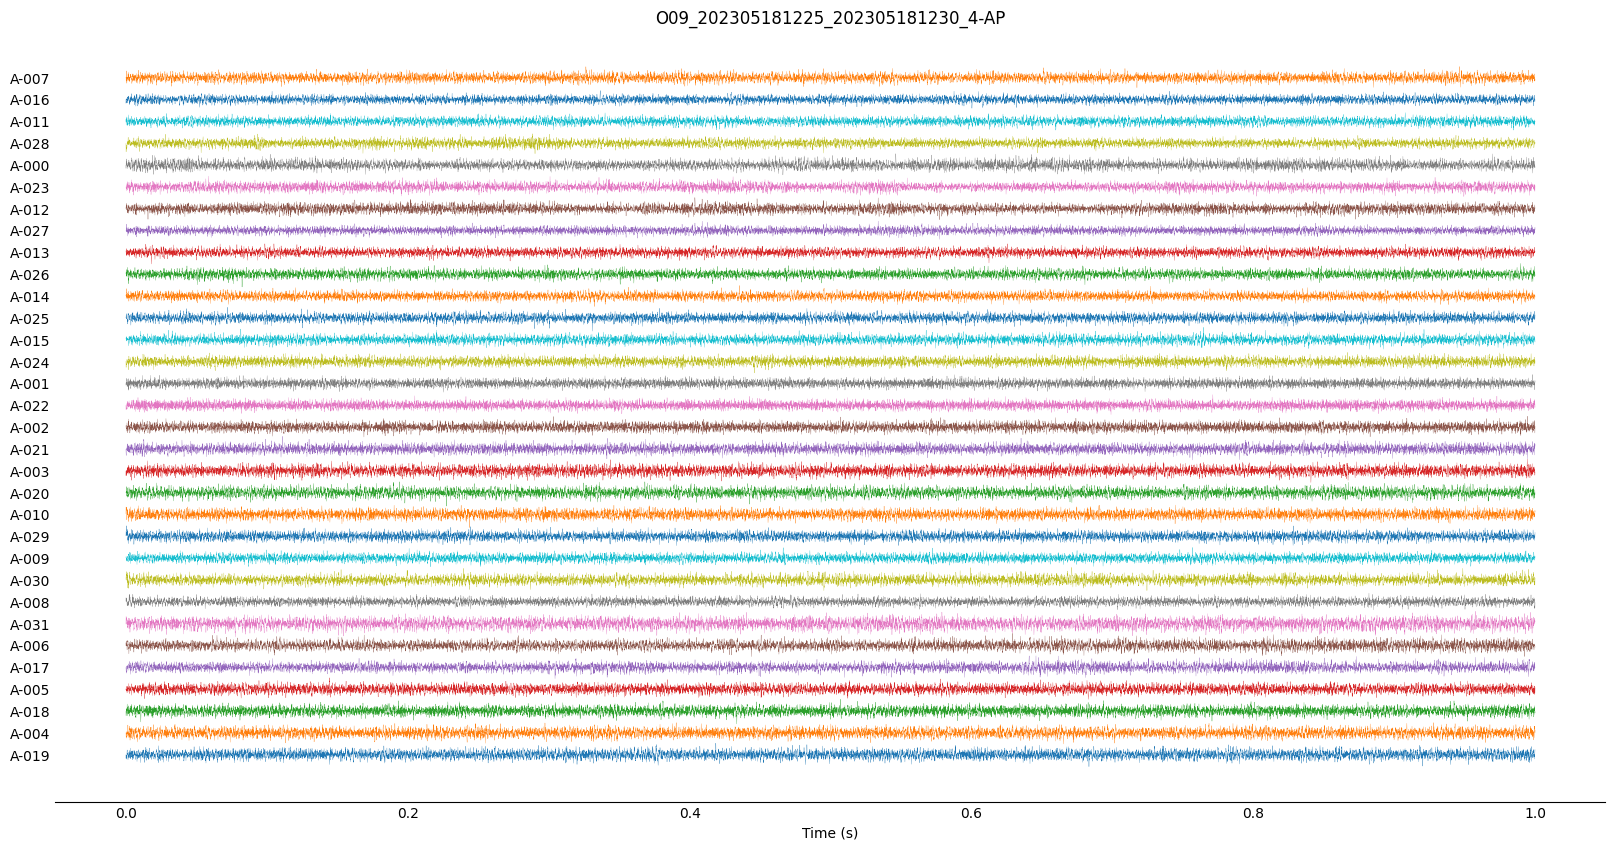

In [ ]:
import seaborn as sns
data = recording_cmr.get_traces(start_frame=0, end_frame=20000, return_scaled=True)

fig, ax = plt.subplots(figsize=(20, 10))
ytick_loc = []
offset = 50

for i in range(data.shape[1]):
    ax.plot(np.r_[:data.shape[0]] / recording_cmr.sampling_frequency, data[:, i] + i * offset, linewidth=0.2)
    ytick_loc.append(i * offset)

ax.set_yticks(ytick_loc)
ax.set_yticklabels([device_channel_indices[i] for i in probe_info["used_electrodes"]])
ax.set_title(title)
ax.tick_params(length=0)
ax.set(xlabel="Time (s)")
sns.despine(right = True, left = True)

if not (spike_sorting_path / "raw_trace.png").exists():
    fig.savefig(spike_sorting_path / "raw_trace.png")

### Run sorter

In [ ]:
from spikeinterface.full import run_sorter

#### spiking circus 2

In [ ]:
# !pip install hdbscan
# !pip install numba

In [ ]:
# Run sorter. Load the sorting data if it already exists
sorter_name = "spykingcircus2"
sorting_folder = spike_sorting_path / sorter_name

if (sorting_folder / "sorting.pkl").exists():
    sorting = si.load_extractor(sorting_folder / "sorting.pkl")
else:
    sorting = run_sorter(recording=recording_cmr, output_folder=sorting_folder, sorter_name=sorter_name, remove_existing_folder=True,
    verbose=True
    )
    
    sorting.dump_to_pickle(file_path=spike_sorting_path / "sorting.pkl")
    # sorting.save(folder=sorting_folder)

detect peaks using locally_exclusive with n_jobs = 4 and chunk_size = 20000


detect peaks using locally_exclusive:   0%|          | 0/1200 [00:00<?, ?it/s]

We found 3115 peaks in total
We kept 3115 peaks for clustering
extracting features with n_jobs = 4 and chunk_size = 20000


extracting features:   0%|          | 0/1200 [00:00<?, ?it/s]

We found 47 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 4 and chunk_size = 20000


extract waveforms shared_memory multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 4 and chunk_size = 20000


extract waveforms shared_memory multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We kept 47 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 4 and chunk_size = 20000


extract waveforms shared_memory multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 4 and chunk_size = 20000


extract waveforms shared_memory multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 4 and chunk_size = 2000


find spikes (circus-omp-svd):   0%|          | 0/12000 [00:00<?, ?it/s]

We found 646212 spikes
spykingcircus2 run time 1318.26s


In [ ]:
sorting.to_dict()

{'class': 'spikeinterface.core.sortingfolder.NumpyFolderSorting',
 'module': 'spikeinterface',
 'kwargs': {'folder_path': '/home/anaconda/efs/outbox/spike_sorting/O09_202305181225_202305181255_4-AP/spykingcircus2/sorter_output/sorting'},
 'version': '0.99.1',
 'relative_paths': False,
 'annotations': {},
 'properties': {}}

In [ ]:
# Waveform extraction
we = si.extract_waveforms(
    recording_cmr,
    sorting,
    folder=sorting_folder / "waveform",
    ms_before=1.5,
    ms_after=2.,
    max_spikes_per_unit=500,
    # overwrite=True,
    load_if_exists=True
)
print(we)

/tmp/ipykernel_218507/165785390.py:3: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  we = si.extract_waveforms(


extract waveforms shared_memory multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1200 [00:00<?, ?it/s]

WaveformExtractor: 32 channels - 47 units - 1 segments
  before:30 after:40 n_per_units:500 - sparse


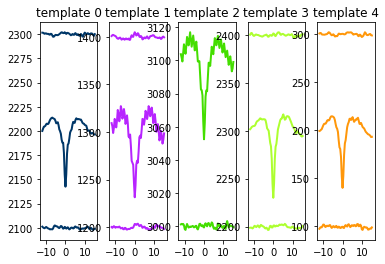

In [ ]:
si.widgets.plot_unit_templates(we, unit_ids=sorting.unit_ids[:5], ncols=5)
# si.widgets.plot_unit_templates(we, ncols=5)

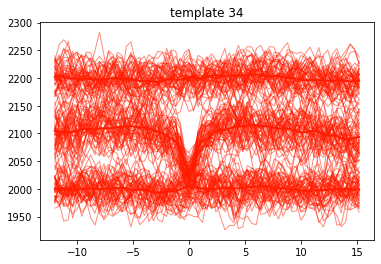

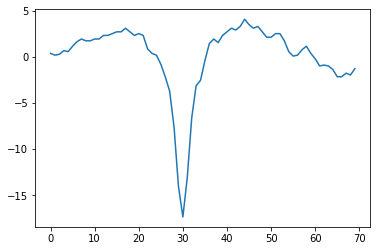

In [ ]:
unit_id = 34
si.widgets.plot_unit_waveforms(we, unit_ids=[sorting.unit_ids[unit_id]])

fig, ax = plt.subplots()
template = we.get_template(unit_id=sorting.unit_ids[unit_id], mode='median')
ax.plot(template[:, 0])
plt.show()

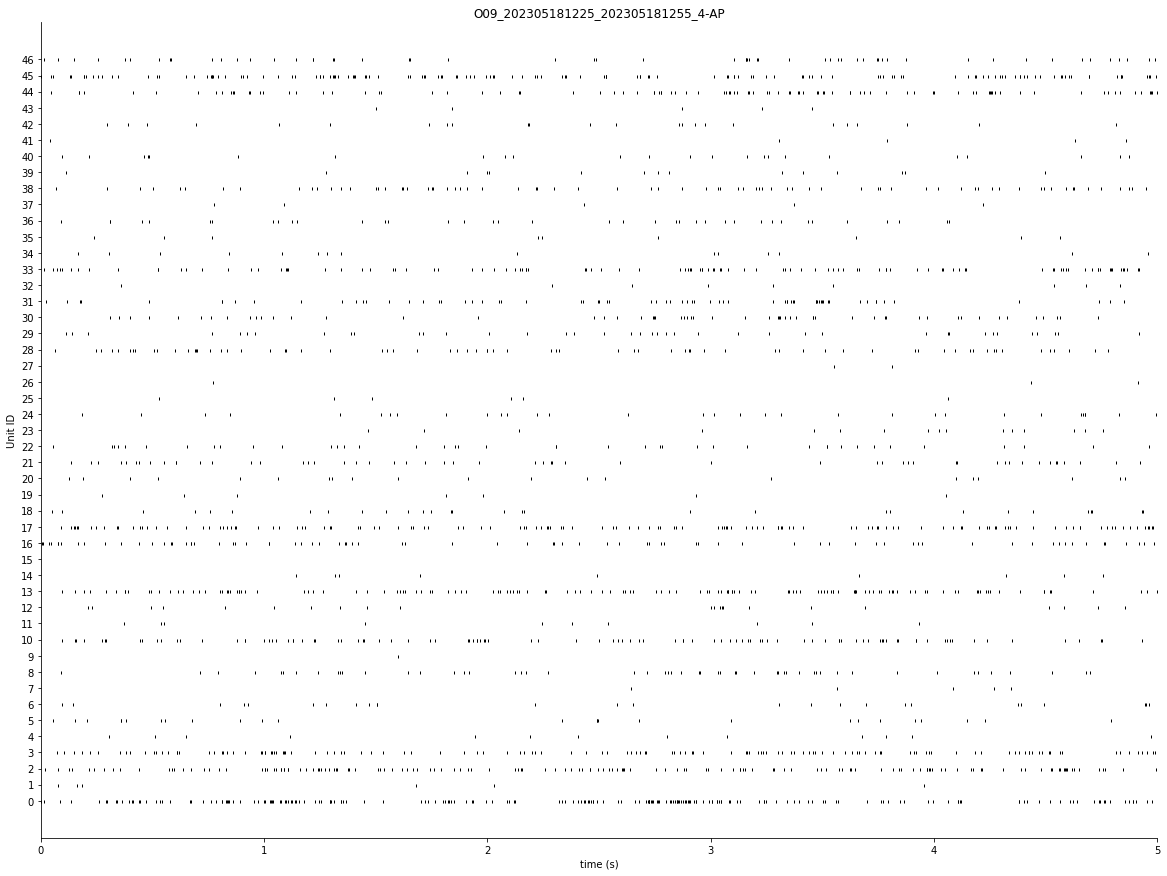

In [ ]:
# Plot rasters
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
si.widgets.plot_rasters(sorting, time_range=[0, 5], ax=ax)
ax.set_ylabel("Unit ID")
ax.set_title(title)
# si.widgets.plot_rasters(sorting, time_range=[0, 5], unit_ids=[unit_id], ax=ax)
sns.despine()

if not (spike_sorting_path / "raster.png").exists():
    fig.savefig(spike_sorting_path / "raster.png")

#### QC metrics

In [ ]:
# Save quality metrics 
metrics = si.qualitymetrics.compute_quality_metrics(
    we,
    metric_names=[
        "firing_rate",
        "snr",
        "presence_ratio",
        "isi_violation",
        "num_spikes",
        "amplitude_cutoff",
        "amplitude_median",
        "sliding_rp_violation",
        "rp_violation",
        "drift",
    ],
)

metrics.to_csv(sorting_folder / "metrics.csv")
metrics

/opt/conda/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [9, 15] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/opt/conda/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:982: UserWarning: The drift metrics require the `spike_locations` waveform extension. Use the `postprocessing.compute_spike_locations()` function. Drift metrics will be set to NaN
  warnings.warn(


,firing_rate,snr,presence_ratio,isi_violations_ratio,isi_violations_count,num_spikes,amplitude_cutoff,amplitude_median,sliding_rp_violation,rp_contamination,rp_violations,drift_ptp,drift_std,drift_mad
0,49.415000,3.104001,1.00,0.391439,3441,59298,0.010956,16.184999,NaN,0.537345,2303,NaN,NaN,NaN
1,1.399167,3.175112,1.00,0.000000,0,1679,0.001592,19.012499,0.285,0.000000,0,NaN,NaN,NaN
2,28.091667,2.890864,1.00,0.267872,761,33710,0.001950,13.455000,0.245,0.288809,468,NaN,NaN,NaN
3,24.776667,2.957080,1.00,0.398194,880,29732,0.002246,19.500000,NaN,0.530099,574,NaN,NaN,NaN
4,4.688333,3.060055,1.00,0.214837,17,5626,0.004622,16.769999,0.250,0.165314,8,NaN,NaN,NaN
5,5.944167,3.165231,1.00,0.448116,57,7133,0.017139,16.184999,NaN,0.611492,36,NaN,NaN,NaN
6,12.041667,3.014362,1.00,0.392716,205,14450,0.003581,17.160000,NaN,0.551492,139,NaN,NaN,NaN
7,1.825833,2.929159,1.00,0.249975,3,2191,0.001425,15.405000,NaN,0.292858,2,NaN,NaN,NaN
8,12.438333,2.725883,1.00,0.366272,204,14926,0.012678,15.405000,NaN,0.452483,130,NaN,NaN,NaN
9,0.040000,4.070571,0.55,694.444444,4,48,NaN,23.984999,NaN,0.000000,0,NaN,NaN,NaN


In [ ]:
# Export to report
# from spikeinterface import exporters
_ = si.postprocessing.compute_spike_amplitudes(waveform_extractor=we)
# _ = si.postprocessing.compute_correlograms(waveform_extractor=we)
_ = si.qualitymetrics.compute_quality_metrics(waveform_extractor=we, metric_names=['snr', 'isi_violation', 'presence_ratio'])

si.exporters.export_report(we, output_folder=sorting_folder / "report")

extract amplitudes:   0%|          | 0/1200 [00:00<?, ?it/s]

export_report(): correlograms will not be exported. Use compute_correlograms() if you want to include them.


#### Kilosort2_5

In [ ]:
# !pip install docker
# !pip install cuda-python

In [ ]:
sorter_name="kilosort2"
sorting_folder = get_processed_root_data_dir() / (key["organoid_id"] + "-" + str(key["start_time"].time()).replace(":", "-")) / sorter_name

sorting_kilosort = run_sorter(
    recording=recording_cmr,
    sorter_name=sorter_name, 
    output_folder=sorting_folder,
    remove_existing_folder=True,
    verbose=True,
    docker_image=True,
)